In [1]:
from typing import List

from oop_functions.experiment_helper import *
from oop_functions.experiment_runner import ExperimentRunner
from oop_functions.util_functions import summarize_features, print_df
from oop_functions.visualization_util import *
from oop_functions.analytics_cv_util import *

%matplotlib inline
import warnings

warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import seaborn as sns

from xgboost import XGBClassifier

import itertools


In [2]:
def load_cv_analytics_util_see_stats(filesuffix):
    cv_analytics_util = CvAnalyticsUtil.load_cv_analytics_utils(filesuffix)
    cv_analytics_util.get_cv_report();
    cv_analytics_util.display_graph()
    return cv_analytics_util

def plot_hist_side_by_side_for_class(df, label, xaxis, normalize = True, title=''):
    # Compute histogram
    plt.style.use('seaborn-deep')
    fig, ax = plt.subplots(1, 1, figsize=(20, 8))
    num_bins = 20
    positive_df = df[df[label] == 1]
    bin_edges = np.linspace(0, 1, num_bins + 1)
    hist_positive, bin_edges = np.histogram(positive_df[xaxis], bins=bin_edges)

    negative_df = df[df[label] == 0]
    hist_negative, bin_edges = np.histogram(negative_df[xaxis], bins=bin_edges)
    if normalize:
        hist_positive = hist_positive / sum(hist_positive)
        hist_negative = hist_negative / sum(hist_negative)
    ax.hist([bin_edges[:-1], bin_edges[:-1]], bin_edges, weights=[hist_positive, hist_negative], label=['positive', 'negative'])
    ax.legend(title=label)
    ax.set_ylabel('Class percentage')
    ax.set_xlabel(xaxis)
    plt.title(title)
    plt.show()

def get_dataset_with_predictions(cv_analytics_util, id_col = 'index', label = 'cancer_in_next_1_years'):
    id_and_confidence = []
    for analytics_util in cv_analytics_util.analytics_utils:
        X_test = analytics_util.data_util.test_df
        X_test_mismatch = X_test.copy()
        y_pred, y_prob = analytics_util.get_predictions() 
        X_test_mismatch[f'{label}_pred'] = y_pred
        X_test_mismatch[f'{label}_prob'] = y_prob
        id_and_confidence.append(X_test_mismatch)
    full_dataset = pd.concat(id_and_confidence)
    return full_dataset



Cross-Validation measures:
+--------------------+----------+-------------+-----------+----------+
|                    |     mean |         std |       min |      max |
|--------------------+----------+-------------+-----------+----------|
| precision__class_0 | 0.999809 | 0.000130793 | 0.99955   | 1        |
| recall__class_0    | 0.996691 | 0.00106357  | 0.994379  | 0.998127 |
| f1-score__class_0  | 0.998247 | 0.00056794  | 0.997003  | 0.99898  |
| precision__class_1 | 0.159825 | 0.0578608   | 0.0597015 | 0.25     |
| recall__class_1    | 0.75463  | 0.166639    | 0.444444  | 1        |
| f1-score__class_1  | 0.261388 | 0.0852791   | 0.106667  | 0.390244 |
| accuracy           | 0.996503 | 0.00113132  | 0.994026  | 0.997964 |
| auc                | 0.992411 | 0.00790166  | 0.968681  | 0.999922 |
+--------------------+----------+-------------+-----------+----------+


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


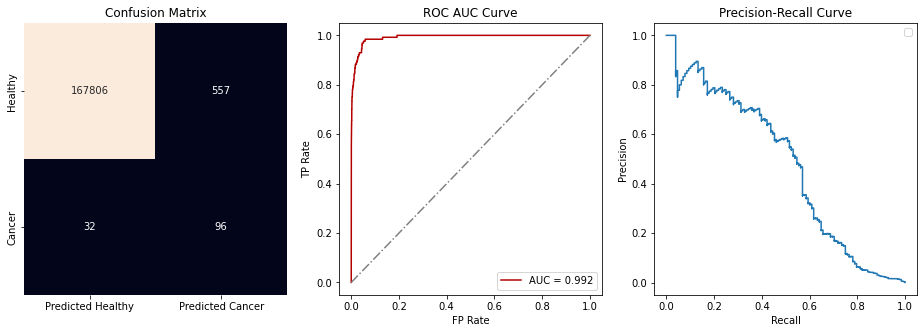

In [3]:
single_cv_analytics_util = load_cv_analytics_util_see_stats('experiment_participants_screened_single_first_5_XGBClassifier_for_cancer_in_next_1_years_15_trials')

In [4]:
single_test_cols = single_cv_analytics_util.analytics_utils[0].data_util.test_df.columns.to_list()

In [5]:
len(single_test_cols)

175

In [6]:
id_col = 'index'
label = 'cancer_in_next_1_years'
id_and_confidence = []
for analytics_util in single_cv_analytics_util.analytics_utils:
    X_test = analytics_util.data_util.test_df[[id_col, 'plco_id', label]]
    X_test_mismatch = X_test.copy()
    y_pred, y_prob = analytics_util.get_predictions() 
    X_test_mismatch[f'{label}_pred'] = y_pred
    X_test_mismatch[f'{label}_prob'] = y_prob
    X_test_mismatch = X_test_mismatch[X_test_mismatch[label] != X_test_mismatch[f'{label}_pred']]
    X_test_mismatch = X_test_mismatch[X_test_mismatch[label] == 1]
    id_and_confidence.append(X_test_mismatch)
mid_conf_predictions = pd.concat(id_and_confidence)



Cross-Validation measures:
+--------------------+-----------+-------------+-----------+----------+
|                    |      mean |         std |       min |      max |
|--------------------+-----------+-------------+-----------+----------|
| precision__class_0 | 0.999639  | 0.000227844 | 0.999016  | 0.999911 |
| recall__class_0    | 0.9957    | 0.00110053  | 0.994319  | 0.997449 |
| f1-score__class_0  | 0.997665  | 0.000569102 | 0.996875  | 0.998547 |
| precision__class_1 | 0.0893576 | 0.0542384   | 0.0153846 | 0.230769 |
| recall__class_1    | 0.528722  | 0.21924     | 0.153846  | 0.833333 |
| f1-score__class_1  | 0.149498  | 0.0816074   | 0.028169  | 0.339623 |
| accuracy           | 0.995343  | 0.001133    | 0.99377   | 0.997098 |
| auc                | 0.962204  | 0.0279664   | 0.898491  | 0.994263 |
+--------------------+-----------+-------------+-----------+----------+


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


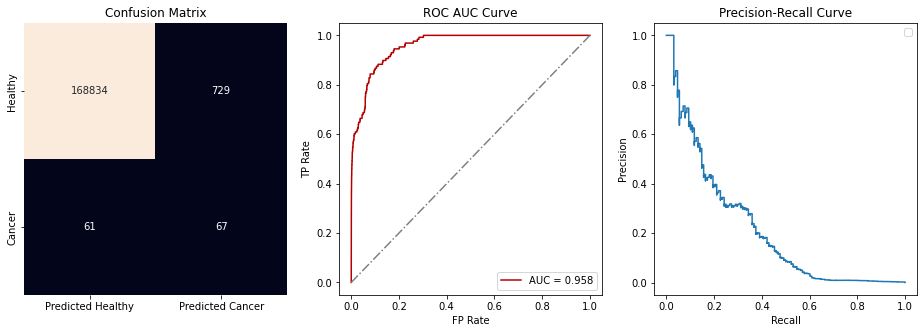

In [7]:
cv_analytics_util = load_cv_analytics_util_see_stats('experiment_participants_screened_first_5_XGBClassifier_for_cancer_in_next_1_years_15_trials')



Cross-Validation measures:
+--------------------+------------+-------------+------------+-----------+
|                    |       mean |         std |        min |       max |
|--------------------+------------+-------------+------------+-----------|
| precision__class_0 | 0.999757   | 0.000175895 | 0.999346   | 1         |
| recall__class_0    | 0.944383   | 0.0052124   | 0.936023   | 0.952686  |
| f1-score__class_0  | 0.971274   | 0.00272901  | 0.966822   | 0.975458  |
| precision__class_1 | 0.00953599 | 0.00452744  | 0.00298507 | 0.0209424 |
| recall__class_1    | 0.692462   | 0.178674    | 0.4        | 1         |
| f1-score__class_1  | 0.0187772  | 0.00882117  | 0.00593472 | 0.0408859 |
| accuracy           | 0.944194   | 0.00515863  | 0.935792   | 0.952118  |
| auc                | 0.962204   | 0.0279664   | 0.898491   | 0.994263  |
+--------------------+------------+-------------+------------+-----------+


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


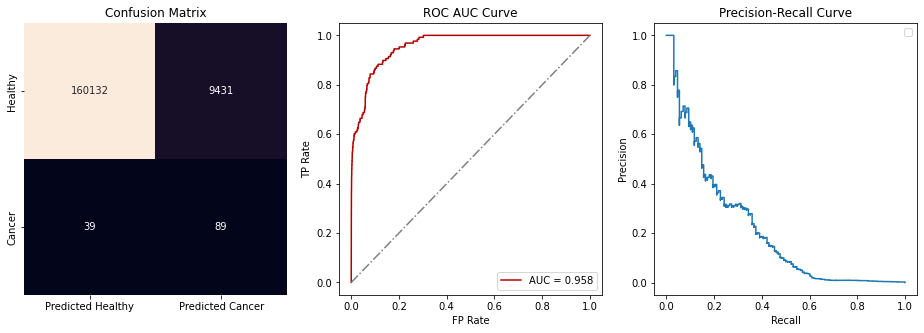

In [8]:
cv_analytics_util.update_thresholds(0.03)
cv_analytics_util.get_cv_report();
cv_analytics_util.display_graph()

In [9]:
test_cols = cv_analytics_util.analytics_utils[0].data_util.test_df.columns.to_list()

In [10]:
for col in test_cols:
    if col not in single_test_cols:
        print(col)

In [107]:
from oop_functions.util_functions import summarize_features, print_df, convert_numeric_to_float16

processed_data = pd.read_csv('./processed_dataset/recent_propagated_dataset.csv', index_col=0)
processed_data = convert_numeric_to_float16(processed_data)

In [110]:
processed_data[processed_data['ovar_cancer_years']  < processed_data['ovar_observe_year']][['ovar_cancer_years', 'study_yr', 'cancer_in_next_1_years', 'ovar_observe_year']]

,ovar_cancer_years,study_yr,cancer_in_next_1_years,ovar_observe_year


In [12]:

processed_data['ca125ii_level_binary'] = np.nan
processed_data.loc[processed_data['ca125ii_level'] < 35, 'ca125ii_level_binary'] = 1
processed_data.loc[processed_data['ca125ii_level'] >= 35 , 'ca125ii_level_binary'] = 2

In [13]:
# TODO: fix this one

In [14]:
full_dataset_single_original = get_dataset_with_predictions(single_cv_analytics_util, id_col = 'index', label = 'cancer_in_next_1_years')

(11270, 175)
(11237, 175)
(11314, 175)
(11244, 175)
(11250, 175)
(11238, 175)
(11311, 175)
(11229, 175)
(11271, 175)
(11204, 175)
(11230, 175)
(11221, 175)
(11294, 175)
(11190, 175)
(11237, 175)


Cross-Validation measures:
+--------------------+------------+-------------+------------+------------+
|                    |       mean |         std |        min |        max |
|--------------------+------------+-------------+------------+------------|
| precision__class_0 | 0.999818   | 0.000144079 | 0.999495   | 1          |
| recall__class_0    | 0.879847   | 0.0056192   | 0.86953    | 0.886442   |
| f1-score__class_0  | 0.935995   | 0.00317779  | 0.93008    | 0.939803   |
| precision__class_1 | 0.00496832 | 0.00091907  | 0.00309358 | 0.00621601 |
| recall__class_1    | 0.793519   | 0.160421    | 0.444444   | 1          |
| f1-score__class_1  | 0.00987441 | 0.00182676  | 0.00614439 | 0.0123552  |
| accuracy           | 0.879778   | 0.00560258  | 0.869356   | 0.886523   |
| auc           

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


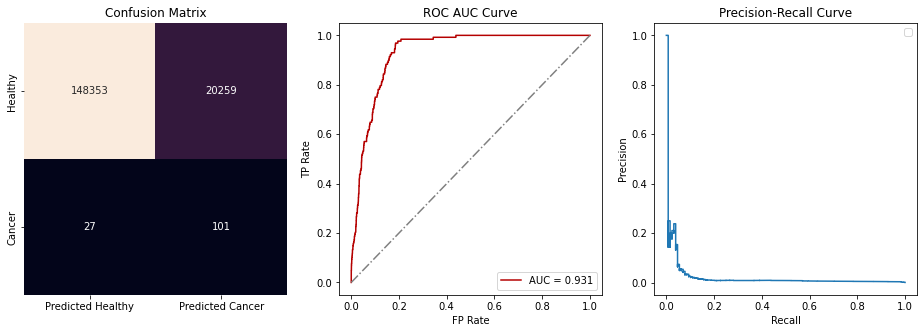

In [15]:
# Create a copy of the whole dataset
label = 'cancer_in_next_1_years'
full_dataset = []
for analytics_util in cv_analytics_util.analytics_utils:
    X_test = analytics_util.data_util.test_df
    full_dataset.append(X_test.copy())
full_dataset = pd.concat(full_dataset)
processed_data = processed_data[full_dataset.columns]
full_dataset = processed_data[processed_data[id_col].isin(full_dataset[id_col])]
# Add those records to the test datasets of the single label dataset and test its validity
for analytics_util in single_cv_analytics_util.analytics_utils:
    idx = analytics_util.data_util.test_df['plco_id'].to_list()
    print((full_dataset[full_dataset['plco_id'].isin(idx)].shape))
    analytics_util.data_util.test_df = full_dataset[full_dataset['plco_id'].isin(idx)]
    analytics_util.data_util.test_df = analytics_util.data_util.imputer.imputer_transform(analytics_util.data_util.test_df)
single_cv_analytics_util.update_thresholds(0.2)
single_cv_analytics_util.get_cv_report();
single_cv_analytics_util.display_graph()

In [16]:
full_dataset_single_new = get_dataset_with_predictions(single_cv_analytics_util, id_col = 'index', label = 'cancer_in_next_1_years')

In [55]:
plco_id = 264657

In [52]:
full_dataset_single_new[full_dataset_single_new['cancer_in_next_1_years_prob'] > 0.9]['index']

21            21.0
29            29.0
104          104.0
113          113.0
232          232.0
            ...   
264657    264657.0
264666    264666.0
264682    264682.0
264686    264686.0
264691    264691.0
Name: index, Length: 10983, dtype: float64

In [56]:
full_dataset_single_original[full_dataset_single_original['index'] == plco_id]

,plco_id,age,agelevel,arthrit_f,asp,asppd,bbd,bcontr_f,bcontra,bcontrt,...,viseith,visl,visr,volum,was_screened,weight20_f,weight50_f,weight_f,cancer_in_next_1_years_pred,cancer_in_next_1_years_prob
11039,Z-158542-3,75.0,3.0,1.0,1.0,6.0,0.0,0.0,1.474609,0.0,...,0.0,0.0,0.0,10.203125,1.0,140.0,150.0,145.0,0,0.002101


In [57]:
full_dataset_single_new[full_dataset_single_new['index'] == plco_id]

,plco_id,age,agelevel,arthrit_f,asp,asppd,bbd,bcontr_f,bcontra,bcontrt,...,viseith,visl,visr,volum,was_screened,weight20_f,weight50_f,weight_f,cancer_in_next_1_years_pred,cancer_in_next_1_years_prob
264657,Z-158542-3,75.0,3.0,1.0,1.0,6.0,0.0,0.0,1.474894,0.0,...,0,0,0,10.202633,1.0,140.0,150.0,145.0,1,0.941463


In [17]:
id_col = 'index'
label = 'cancer_in_next_1_years'
id_and_confidence = []
for analytics_util in cv_analytics_util.analytics_utils:
    X_test = analytics_util.data_util.test_df[[id_col, 'plco_id', label]]
    X_test_mismatch = X_test.copy()
    y_pred, y_prob = analytics_util.get_predictions() 
    X_test_mismatch[f'{label}_pred'] = y_pred
    X_test_mismatch[f'{label}_prob'] = y_prob
    X_test_mismatch = X_test_mismatch[X_test_mismatch[label] != X_test_mismatch[f'{label}_pred']]
    X_test_mismatch = X_test_mismatch[X_test_mismatch[label] == 1]
    id_and_confidence.append(X_test_mismatch)
mid_conf_predictions_2 = pd.concat(id_and_confidence)

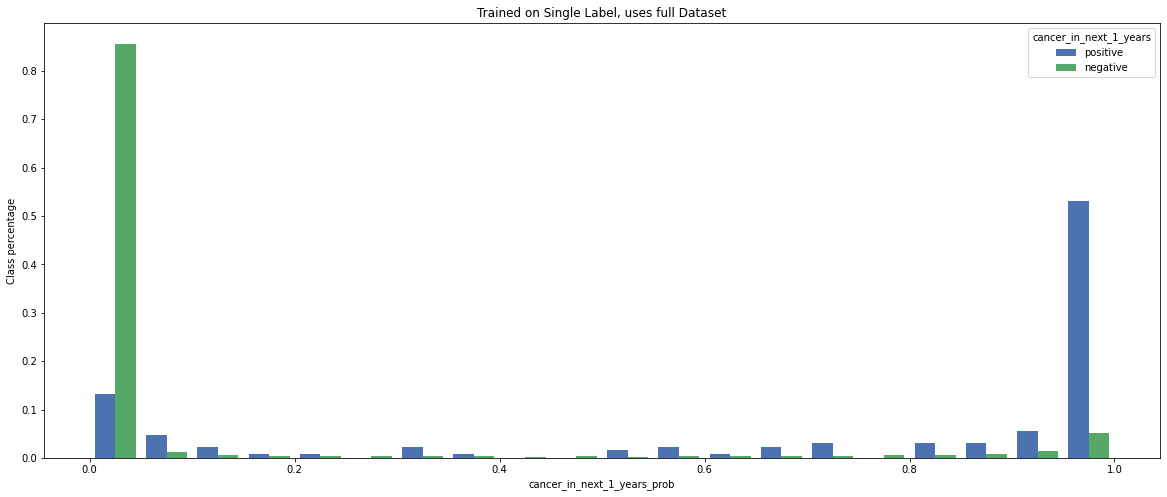

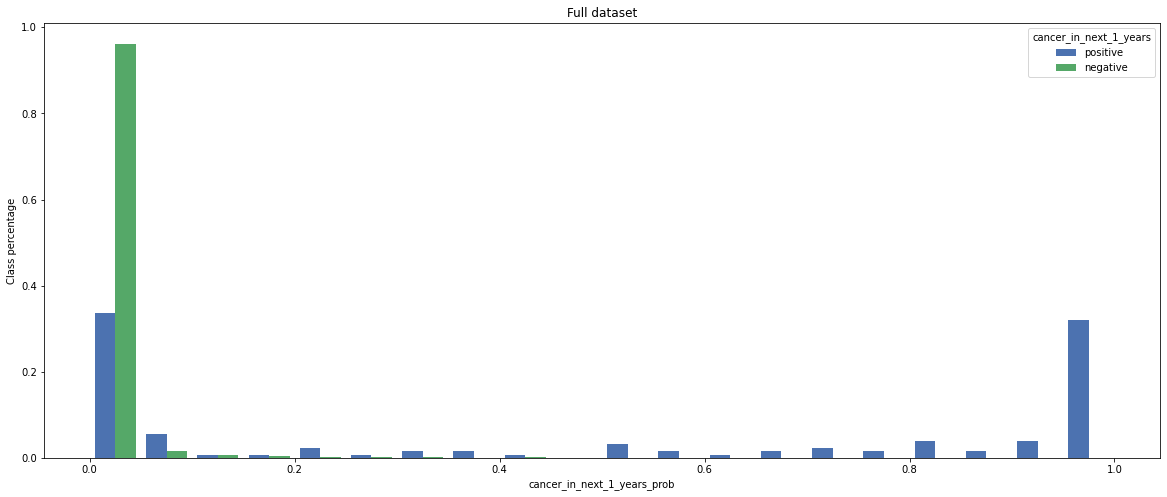

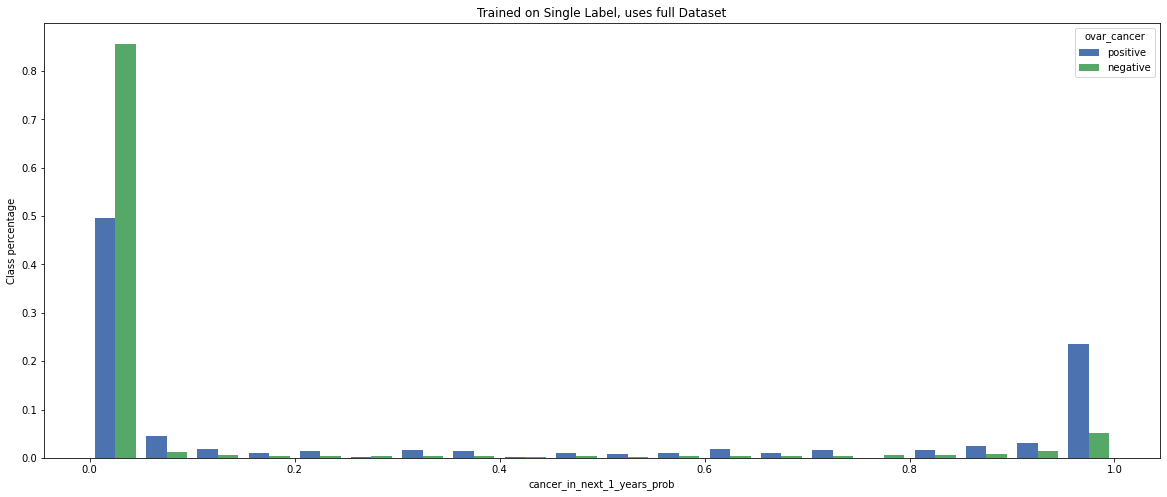

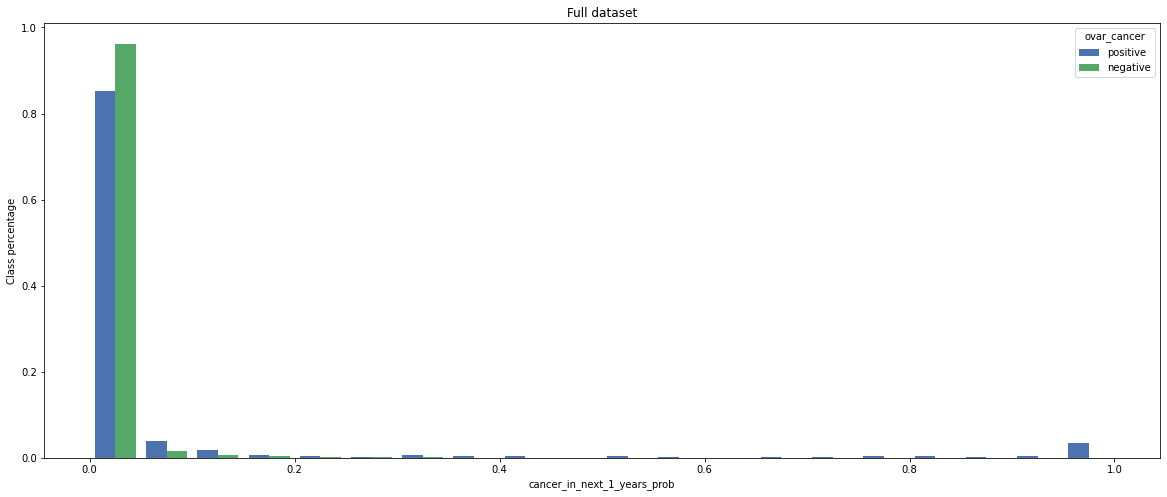

In [18]:

full_dataset = get_dataset_with_predictions(single_cv_analytics_util, id_col = 'index', label = 'cancer_in_next_1_years')
plot_hist_side_by_side_for_class(full_dataset, 'cancer_in_next_1_years', 'cancer_in_next_1_years_prob', normalize = True, title='Trained on Single Label, uses full Dataset')
full_dataset = get_dataset_with_predictions(cv_analytics_util, id_col = 'index', label = 'cancer_in_next_1_years')
plot_hist_side_by_side_for_class(full_dataset, 'cancer_in_next_1_years', 'cancer_in_next_1_years_prob', normalize = True, title='Full dataset')

full_dataset = get_dataset_with_predictions(single_cv_analytics_util, id_col = 'index', label = 'cancer_in_next_1_years')
plot_hist_side_by_side_for_class(full_dataset, 'ovar_cancer', 'cancer_in_next_1_years_prob', normalize = True, title='Trained on Single Label, uses full Dataset')
full_dataset = get_dataset_with_predictions(cv_analytics_util, id_col = 'index', label = 'cancer_in_next_1_years')
plot_hist_side_by_side_for_class(full_dataset, 'ovar_cancer', 'cancer_in_next_1_years_prob', normalize = True, title='Full dataset')

In [19]:
print([col for col in full_dataset.columns if 'year' in col])

['cancer_in_next_1_years', 'cig_years', 'ovar_cancer_years', 'ovar_observe_year', 'pack_years', 'cancer_in_next_1_years_pred', 'cancer_in_next_1_years_prob']




Cross-Validation measures:
+--------------------+------------+-------------+------------+------------+
|                    |       mean |         std |        min |        max |
|--------------------+------------+-------------+------------+------------|
| precision__class_0 | 0.999347   | 0.000177823 | 0.998987   | 0.999583   |
| recall__class_0    | 0.949231   | 0.00519343  | 0.940081   | 0.956796   |
| f1-score__class_0  | 0.973637   | 0.00269531  | 0.968862   | 0.977611   |
| precision__class_1 | 0.00660646 | 0.00218433  | 0.00359281 | 0.00995025 |
| recall__class_1    | 0.354107   | 0.115325    | 0.210526   | 0.555556   |
| f1-score__class_1  | 0.012961   | 0.00427544  | 0.00708383 | 0.0195503  |
| accuracy           | 0.948659   | 0.00511047  | 0.939618   | 0.956211   |
| auc                | 0.884351   | 0.028115    | 0.822634   | 0.930396   |
+--------------------+------------+-------------+------------+------------+


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


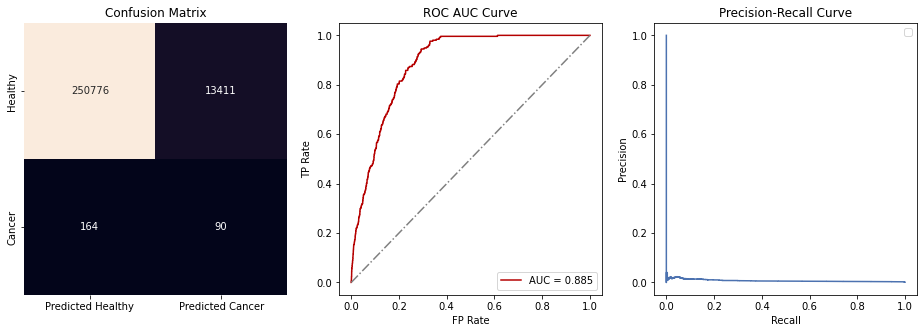

In [36]:
cv_analytics_util_not_screened = load_cv_analytics_util_see_stats('experiment_not_screened_cols_first_5_XGBClassifier_for_cancer_in_next_1_years_15_trials')

In [97]:
def extract_full_dataset_filter_cancer(cv_analytics_util):
    full_dataset = get_dataset_with_predictions(cv_analytics_util, id_col = 'index', label = 'cancer_in_next_1_years')
    full_dataset = full_dataset[full_dataset['ovar_cancer'] == 1]
    full_dataset = full_dataset[full_dataset['ovar_cancer_years'] <= 5]
    return full_dataset

def plot_diff_in_confidence(full_dataset, title=''):
    
    grouped_df = full_dataset.groupby(['plco_id'])
    diff_df = []

    for key, item in grouped_df:
        diff = {}
        group = grouped_df.get_group(key)
        group = group.sort_values('study_yr').reset_index()
        diff['plco_id'] = group.loc[0, 'plco_id']
        years = group['study_yr'].unique()
        max_year = 6 - len(years)
        # max_year = 0
        for year in range(len(years) - 1):
            diff[f'cancer_in_next_1_years_{int(max_year + year+1)}-{int(max_year + year)}'] = group.loc[year+1, 'cancer_in_next_1_years_prob'] - group.loc[year, 'cancer_in_next_1_years_prob']
            # if len(years) == 5:
            #     print(diff)
        diff_df.append(diff)

    ordered_cols = []
    for i in range(5):
        ordered_cols.append(f'cancer_in_next_1_years_{i+1}-{i}')
        
    diff_df = pd.DataFrame(diff_df)

    diff_df = diff_df[['plco_id'] + ordered_cols]
    print_df(diff_df.describe().T)
    x = list(range(-1, -6, -1))
    stats = diff_df.describe()
    y = np.array(stats.loc['mean'].to_list())
    ci = np.array(stats.loc['std'].to_list())
    plt.plot(x, y)
    plt.fill_between(x, (y-ci), (y+ci), color='b', alpha=.1)
    plt.ylabel("Probability of getting cancer")
    plt.xlabel("Years before getting cancer")
    plt.ylim([0, 1])
    plt.title(title)

In [98]:
def plot_change_in_confidence(full_dataset, title = ''):    
    grouped_df = full_dataset.groupby(['plco_id'])
    diff_df = []

    for key, item in grouped_df:
        diff = {}
        group = grouped_df.get_group(key)
        group = group.sort_values('study_yr').reset_index()
        diff['plco_id'] = group.loc[0, 'plco_id']
        years = group['study_yr'].unique()
        max_year = 6 - len(years)
        # max_year = 0
        for year in range(len(years)):
            diff[f'cancer_in_next_1_years_{int(max_year + year)}'] = group.loc[year, 'cancer_in_next_1_years_prob']
            # if len(years) == 5:
            #     print(diff)
        diff_df.append(diff)

    ordered_cols = []
    for i in range(6):
        ordered_cols.append(f'cancer_in_next_1_years_{i}')

    diff_df = pd.DataFrame(diff_df)

    diff_df = diff_df[['plco_id'] + ordered_cols]
    print_df(diff_df.describe().T)
    x = sorted(list(range(-1, -7, -1)))
    stats = diff_df.describe()
    y = np.array(stats.loc['mean'].to_list())
    ci = np.array(stats.loc['std'].to_list())
    plt.plot(x, y)
    plt.fill_between(x, (y-ci), (y+ci), color='b', alpha=.1)
    plt.ylabel("Probability of getting cancer")
    plt.xlabel("Years before getting cancer")
    plt.ylim([0, 1])
    plt.title(title)

In [73]:
list(range(-1, -7, -1))

[-1, -2, -3, -4, -5, -6]

In [90]:
# plot_diff_in_confidence(cv_analytics_util_not_screened, title='Year over year change in probability before getting cancer based on questionaire')

X-axis -1 means that somewhere withing the next year person gets cancer. -2 means somewhere between year -1 and 0 person gets cancer.

+--------------------------+---------+----------+----------+-------------+-----------+----------+----------+----------+
|                          |   count |     mean |      std |         min |       25% |      50% |      75% |      max |
|--------------------------+---------+----------+----------+-------------+-----------+----------+----------+----------|
| cancer_in_next_1_years_0 |       9 | 0.317342 | 0.318214 | 0.0208236   | 0.0475289 | 0.133017 | 0.500486 | 0.819302 |
| cancer_in_next_1_years_1 |      25 | 0.25649  | 0.258817 | 0.0101954   | 0.0597458 | 0.177911 | 0.333263 | 0.859784 |
| cancer_in_next_1_years_2 |      46 | 0.355826 | 0.306703 | 0.00319811  | 0.0755405 | 0.351993 | 0.510005 | 0.966462 |
| cancer_in_next_1_years_3 |      65 | 0.367226 | 0.305189 | 0.00319811  | 0.087126  | 0.326196 | 0.594482 | 0.966462 |
| cancer_in_next_1_years_4 |      95 | 0.375939 | 0.295646 | 0.00319811  | 0.0928115 | 0.326196 | 0.623308 | 0.966462 |
| cancer_in_next_1_years_5 |     254 | 0

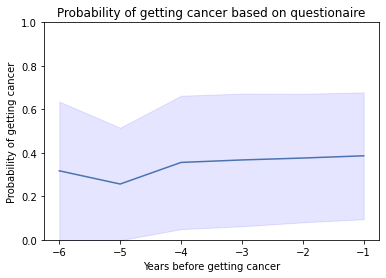

In [99]:
full_dataset = extract_full_dataset_filter_cancer(cv_analytics_util_not_screened)
plot_change_in_confidence(full_dataset, title='Probability of getting cancer based on questionaire')

+--------------------------+---------+-----------+-----------+-------------+------------+------------+------------+-----------+
|                          |   count |      mean |       std |         min |        25% |        50% |        75% |       max |
|--------------------------+---------+-----------+-----------+-------------+------------+------------+------------+-----------|
| cancer_in_next_1_years_0 |       9 | 0.0163439 | 0.0291449 | 0.000411198 | 0.00139162 | 0.00194005 | 0.00313907 | 0.0694696 |
| cancer_in_next_1_years_1 |      25 | 0.04183   | 0.0996112 | 0.000267699 | 0.00127546 | 0.00608086 | 0.0189528  | 0.425671  |
| cancer_in_next_1_years_2 |      46 | 0.0516974 | 0.142414  | 0.000366946 | 0.00222657 | 0.00740373 | 0.0323199  | 0.89563   |
| cancer_in_next_1_years_3 |      65 | 0.0631008 | 0.14163   | 0.000325001 | 0.00405372 | 0.0133242  | 0.0600953  | 0.963983  |
| cancer_in_next_1_years_4 |      95 | 0.113298  | 0.233064  | 0.000451754 | 0.00455551 | 0.0142727  | 0

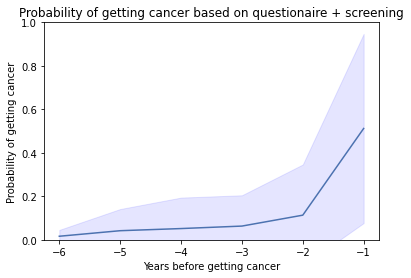

In [142]:
full_dataset = extract_full_dataset_filter_cancer(cv_analytics_util)
plot_change_in_confidence(full_dataset, title='Probability of getting cancer based on questionaire + screening')

+--------------------------+---------+------------+-----------+-------------+-------------+-------------+------------+----------+
|                          |   count |       mean |       std |         min |         25% |         50% |        75% |      max |
|--------------------------+---------+------------+-----------+-------------+-------------+-------------+------------+----------|
| cancer_in_next_1_years_0 |   21891 | 0.00724434 | 0.0409011 | 2.82721e-05 | 0.000136709 | 0.000257214 | 0.00098122 | 0.994937 |
| cancer_in_next_1_years_1 |   25366 | 0.00832935 | 0.0468976 | 2.45247e-05 | 0.000135728 | 0.000259028 | 0.00117774 | 0.997326 |
| cancer_in_next_1_years_2 |   27192 | 0.00884363 | 0.0490938 | 2.68334e-05 | 0.000137727 | 0.00026863  | 0.0013461  | 0.992359 |
| cancer_in_next_1_years_3 |   28787 | 0.0101115  | 0.0563615 | 2.68334e-05 | 0.000138803 | 0.000275306 | 0.00155531 | 0.994668 |
| cancer_in_next_1_years_4 |   30816 | 0.0120544  | 0.0629447 | 2.69068e-05 | 0.000154865 

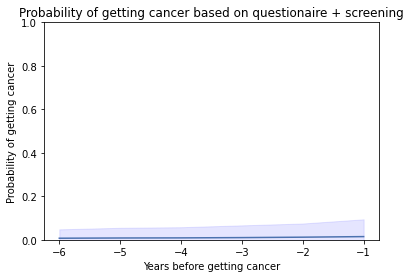

In [145]:
full_dataset = get_dataset_with_predictions(cv_analytics_util, id_col = 'index', label = 'cancer_in_next_1_years')
plot_change_in_confidence(full_dataset, title='Probability of getting cancer based on questionaire + screening')

In [190]:
full_dataset = get_dataset_with_predictions(cv_analytics_util, id_col = 'index', label = 'cancer_in_next_1_years')

threshold = 0.2
idx = full_dataset[(full_dataset['cancer_in_next_1_years_prob'] >= threshold) & (full_dataset['ovar_cancer'] == 0)]['plco_id'].unique()
full_dataset = full_dataset[full_dataset['plco_id'].isin(idx)]
full_dataset = full_dataset[full_dataset['study_yr'] >= 0]
full_dataset = full_dataset[full_dataset['ovar_observe_year'] <= 5]
dict_years_pred = {}
 
for plco_id in full_dataset['plco_id'].unique():
    # TODO: i can change min and max
    dict_years_pred[plco_id] = full_dataset[(full_dataset['plco_id'] == plco_id) & (full_dataset['cancer_in_next_1_years_prob'] >= threshold)]['ovar_observe_year'].min()
    full_dataset = full_dataset[((full_dataset['plco_id'] == plco_id) & (full_dataset['ovar_observe_year'] <= dict_years_pred[plco_id])) | (full_dataset['plco_id'] != plco_id)]

+--------------------------+---------+-----------+-----------+-------------+------------+-----------+-----------+----------+
|                          |   count |      mean |       std |         min |        25% |       50% |       75% |      max |
|--------------------------+---------+-----------+-----------+-------------+------------+-----------+-----------+----------|
| cancer_in_next_1_years_0 |      29 | 0.0369137 | 0.0388441 | 0.000568462 | 0.0048202  | 0.0229451 | 0.0515037 | 0.131665 |
| cancer_in_next_1_years_1 |      98 | 0.0400358 | 0.0493229 | 0.000341451 | 0.00625155 | 0.0196533 | 0.0504637 | 0.19749  |
| cancer_in_next_1_years_2 |     183 | 0.0407395 | 0.044673  | 0.00041329  | 0.00770892 | 0.0241495 | 0.0597662 | 0.19749  |
| cancer_in_next_1_years_3 |     297 | 0.0468503 | 0.0529643 | 0.000379445 | 0.00688779 | 0.0233203 | 0.0664498 | 0.199521 |
| cancer_in_next_1_years_4 |     469 | 0.0514229 | 0.0535136 | 0.000186474 | 0.00929353 | 0.0281106 | 0.0831321 | 0.198212 |


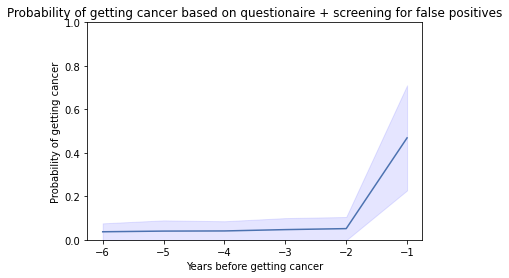

In [191]:
# full_dataset = full_dataset[full_dataset['cancer_in_next_1_years_prob'] >= threshold]
plot_change_in_confidence(full_dataset, title='Probability of getting cancer based on questionaire + screening for false positives')